---
title: "convolution theorem"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

Way back then, we learned about sliding windows and how to take advantage of them for smoothing a signal. We did not give much emphasis to this [then](smoothing/sliding.html#math), but the mathematical operation of sliding a window with a given kernel over a signal is called **convolution**. Let's recall what is the definition of convolution.

The definition of a convolution between signal $f(t)$ and kernel $k(t)$ is

$$
(f * k)(t) = \int f(\tau)k(t-\tau)d\tau.
$$

The expression $f*k$ denotes the convolution of these two functions.
The argument of $k$ is $t-\tau$, meaning that the kernel runs from left to right (as $t$ does), and at every point the two signals ($f$ and $k$) are multiplied together.
It is the product of the signal with the weight function $k$ that gives us an average.
Because of $-\tau$, the kernel is flipped backwards, but this has no effect to symmetric kernels.


## theorem

> The Fourier transform of a convolution is the product of the Fourier transforms of each convolved functions.

In mathematical language:

$$
F[f * g] = F[f] \cdot F[g]
$$

This means that if we want to smooth a function $f$ by averaging a sliding window of a given kernel $g$, we can instead compute the Fourier transform of $f$ and $g$ separately, multiply them together, and finally perform an inverse Fourier transform of this product:

$$
\text{smooth function} = F^{-1}\Big[F[\text{signal}] \cdot F[\text{kernel}] \Big]
$$

**Why is this useful?**

1. Sometimes it is computationally more efficient to compute Fourier transforms than to compute running averages. This is not obvious at all, but there are very fast algorithms that can calculate the Fourier transform in a heartbeat. As we will see later, the `numpy.convolve` tool calculates running averages (convolutions) the usual way for short arrays, and automatically switches its method when it evaluates that using the Fourier transform might be faster (usually for arrays longer than 500 points).
1. Thinking about the Fourier signature of different kernels can be extremely useful to achieve precise goals, such as filtering out specific frequencies from your signal, or to avoid undesirable effects of using a sliding window when you don't exactly know what you are doing.

## kernels and their spectral signatures

In [24]:
#| code-summary: "import stuff"
import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)  # white graphs, with large and legible letters
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

In [25]:
#| code-summary: "define useful functions"
def plot_window_response(name, func, args, ax_left, ax_right, resp="None"):
    window = func(51, **args)
    ax_left.plot(window)
    ax_left.set(ylim=[-0.05, 1.05])
    ax_left.text(0.01, 0.97, name, transform=ax_left.transAxes,
         horizontalalignment='left', verticalalignment='top',)
    A = fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    if resp == "dB": response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    else: response = np.abs(fftshift(A / abs(A).max()))
    ax_right.plot(freq, response)
    ax_right.set(xlim=[-0.5, 0.5,])
    if resp == "dB": ax_right.set(ylim=[-120, 0])
    ax_right.yaxis.tick_right()

names = ["gaussian", "triangle", "boxcar (rectangle)", "exponential", "hann"]
args = [{'std':7},{},{}, {'tau':3.0}, {}]
windows = [signal.windows.gaussian, signal.windows.triang, signal.windows.boxcar, signal.windows.exponential, signal.windows.hann]

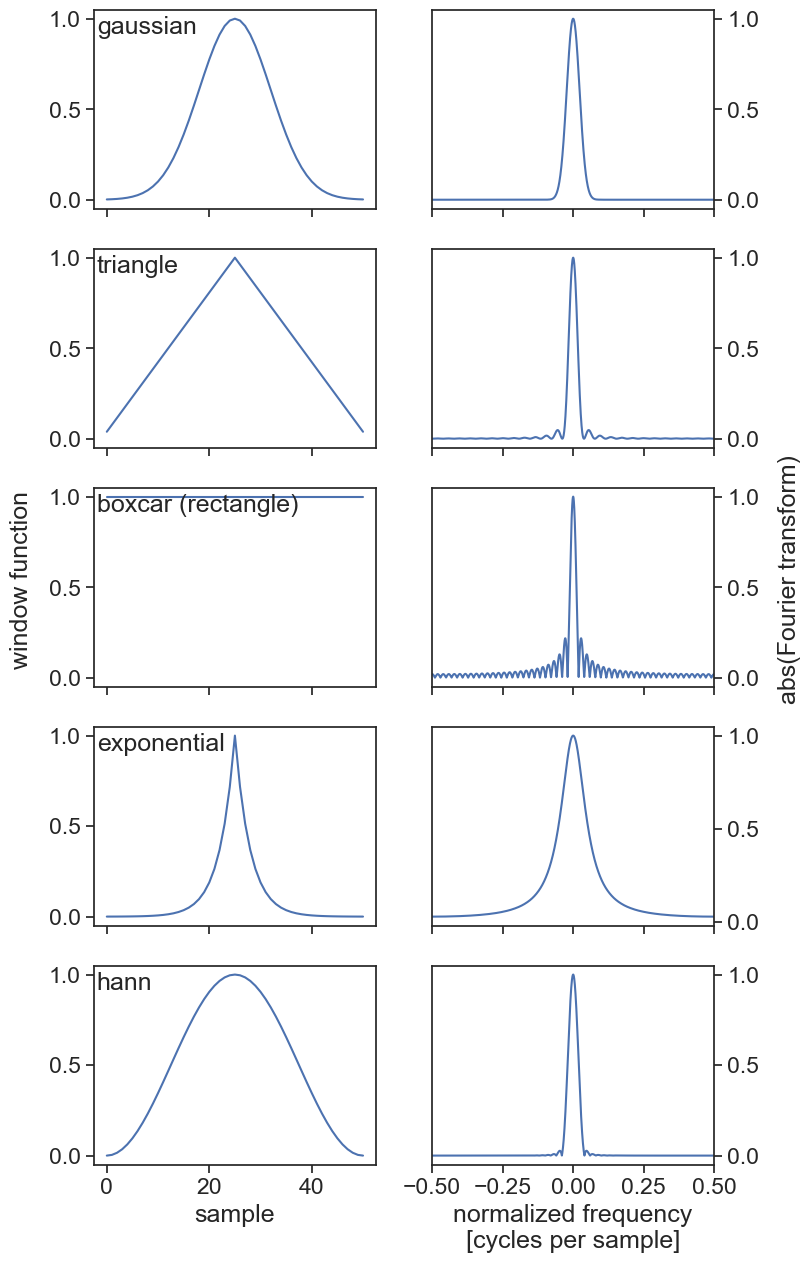

In [26]:
#| code-summary: "plot window function and reponse"
n = 5
fig, ax = plt.subplots(n, 2, figsize=(8,3*n), sharex='col')

for i in range(n):
    plot_window_response(names[i], windows[i], args[i], ax[i,0], ax[i,1])
fig.text(0.02, 0.5, 'window function', va='center', rotation='vertical')
fig.text(0.98, 0.5, 'abs(Fourier transform)', va='center', rotation='vertical')
ax[n-1,0].set(xlabel="sample")
ax[n-1,1].set(xlabel="normalized frequency\n[cycles per sample]");

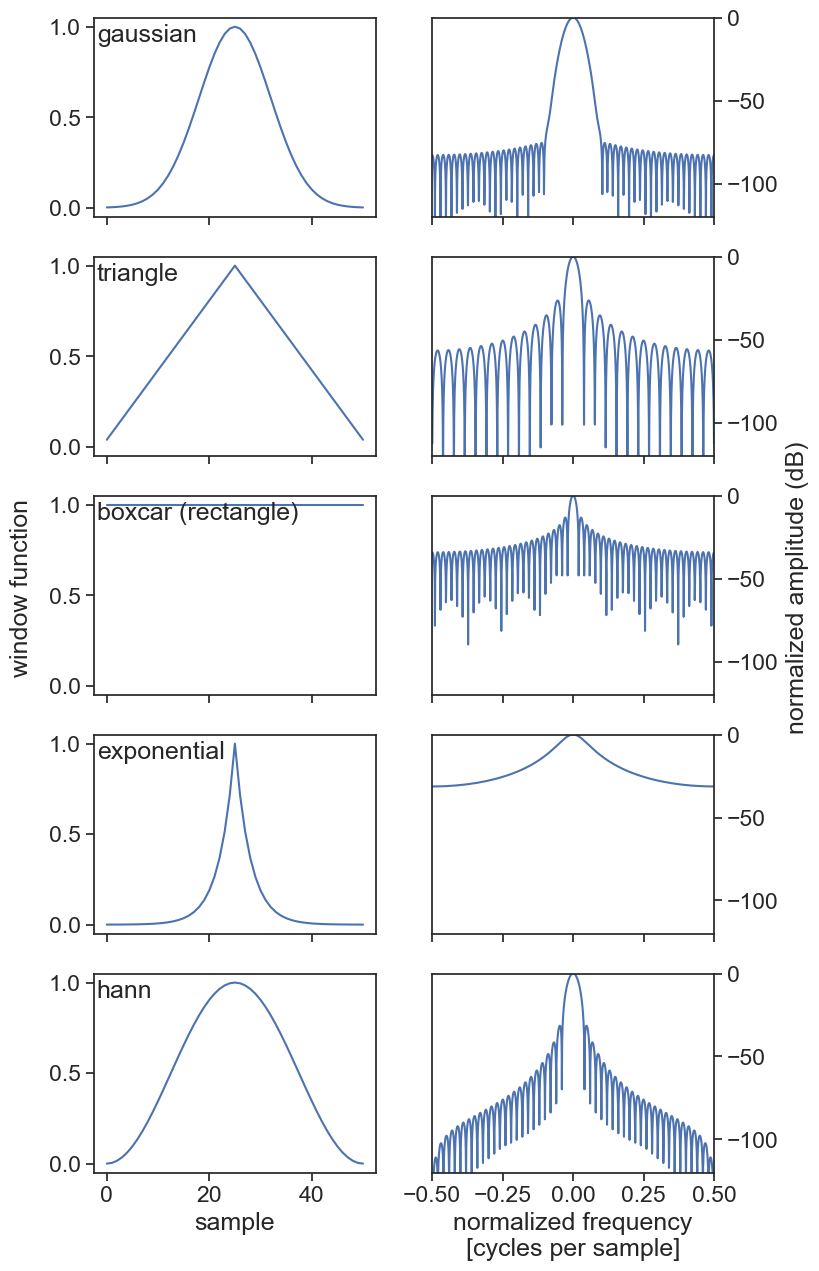

In [27]:
#| code-summary: "plot window function and reponse"
n = 5
fig, ax = plt.subplots(n, 2, figsize=(8,3*n), sharex='col')

for i in range(n):
    plot_window_response(names[i], windows[i], args[i], ax[i,0], ax[i,1], resp="dB")
fig.text(0.02, 0.5, 'window function', va='center', rotation='vertical')
fig.text(0.99, 0.5, 'normalized amplitude (dB)', va='center', rotation='vertical')
ax[n-1,0].set(xlabel="sample")
ax[n-1,1].set(xlabel="normalized frequency\n[cycles per sample]");

## theorem in action

Let's apply the convolution theorem to a real-life time series. See below the temperature of the Shani station over the month of May 2020.

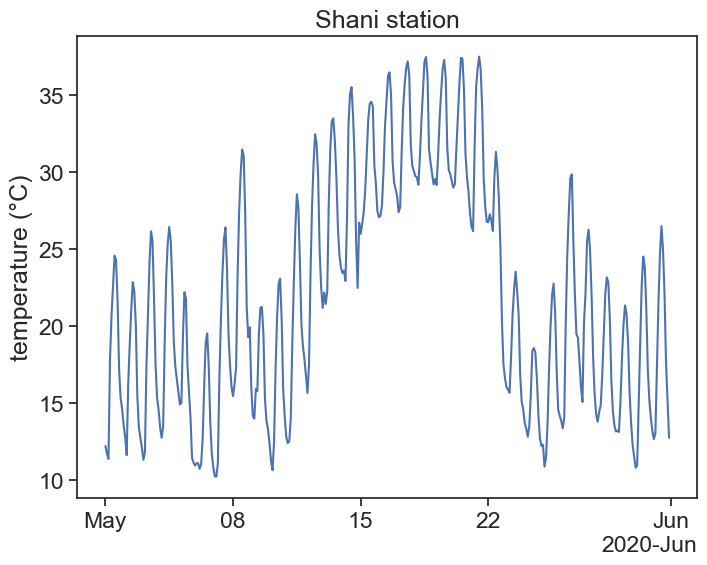

In [28]:
#| code-summary: "load temperature data and plot it"

def concise(ax):
    """
    Let python choose the best xtick labels for you
    """
    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
                                 
df = pd.read_csv('shani_temperature.csv', index_col='datetime', parse_dates=True)
df = df.loc['2020-05-01':'2020-05-31', 'T'].to_frame()
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# df['T'].plot(ylabel="temperature (°C)",
#              xlabel="",
#              title="Shani station")
ax.plot(df['T'])
ax.set(ylabel="temperature (°C)",
             title="Shani station")
concise(ax);

In [29]:
#| code-fold: false
# according to the dataframe, temperature is sampled every 2 hours
dt = 2.0  # hours
N = len(df)
time = np.arange(N) * dt
fft_orig = scipy.fft.fft(df['T'].values)
# this shifted version is useful only for plotting, it looks nicer
fft = scipy.fft.fftshift(fft_orig)
xi = scipy.fft.fftfreq(N, dt)
xi = scipy.fft.fftshift(xi)
fft_abs = np.abs(fft)

# boxcar (rectangular) window
width_hours = 24
width_points = int(width_hours/dt)
boxcar = signal.windows.boxcar(width_points)
# integral of boxcar must be 1.0 if we want to take an average
boxcar = boxcar / np.sum(boxcar)
# we need an array of the same size of the original signal
boxcar_array = np.zeros(N)
# boxcar is placed at the beginning
boxcar_array[:width_points] = boxcar
# if we were to leave the boxcar array as above, the average would not be centered
# let's move the boxcar a half width to the left
boxcar_array = np.roll(boxcar_array, -width_points//2)
# compute Fourier transform of boxcar
fft_boxcar_orig = scipy.fft.fft(boxcar_array)
# shift it only so we can plot it later
fft_boxcar = scipy.fft.fftshift(fft_boxcar_orig)
fft_abs_boxcar = np.abs(fft_boxcar)

# this is the important part
# 1. we multiply the signal's fft with the window's fft
fft_filtered = fft_orig * fft_boxcar_orig
# 2. we apply an inverse Fourier transform. we take only the real part
# because usually the inverse operation yields really small imaginary components
filtered = scipy.fft.ifft(fft_filtered).real

# for comparison's sake, let's apply the usual rolling average
df['rolling1day'] = df['T'].rolling('24H', center=True).mean()

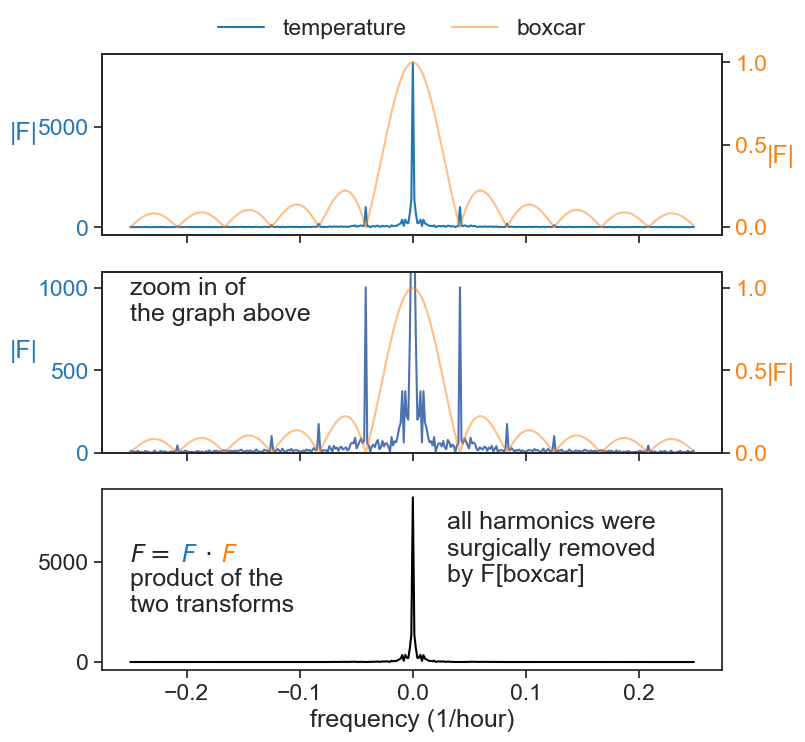

In [30]:
#| code-summary: "power spectrum of signal and window function"
fig, ax = plt.subplots(3, 1, figsize=(8,8), sharex=True)
ax[0].plot(xi, fft_abs, label="temperature", color="tab:blue")
ax[0].set_ylabel("|F|", color="tab:blue", rotation="horizontal", labelpad=10)
ax20 = ax[0].twinx()
ax20.plot(xi, fft_abs_boxcar, label="boxcar", color="tab:orange", alpha=0.5)
ax20.set_ylabel("|F|", color="tab:orange", rotation="horizontal", labelpad=10)
fig.legend(frameon=False, ncol=2,bbox_to_anchor=(0.5,0.95),loc="upper center",)
[t.set_color("tab:blue") for t in ax[0].yaxis.get_ticklines()]
[t.set_color("tab:blue") for t in ax[0].yaxis.get_ticklabels()]
[t.set_color("tab:orange") for t in ax20.yaxis.get_ticklines()]
[t.set_color("tab:orange") for t in ax20.yaxis.get_ticklabels()]

ax[1].plot(xi, fft_abs, label="temperature", zorder=1)
ax[1].set_ylabel("|F|", color="tab:blue", rotation="horizontal", labelpad=10)
ax21 = ax[1].twinx()
ax21.plot(xi, fft_abs_boxcar, label="boxcar", color="tab:orange", alpha=0.5)
ax21.set_ylabel("|F|", color="tab:orange", rotation="horizontal", labelpad=10)
ax[1].set(ylim=[0, 1100])
ax21.set(ylim=[0,1.1])
[t.set_color("tab:blue") for t in ax[1].yaxis.get_ticklines()]
[t.set_color("tab:blue") for t in ax[1].yaxis.get_ticklabels()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklines()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklabels()]
ax21.text(-0.25, 0.80, "zoom in of\nthe graph above")

ax[2].plot(xi, np.abs(scipy.fft.fftshift(fft_filtered)), color="black")
ax[2].text(-0.25, 2500, "product of the\ntwo transforms")
ax[2].text(-0.25, 5000, r"$F=\quad \cdot$")
ax[2].text(-0.205, 5000, r"$F$", color="tab:blue")
ax[2].text(-0.17, 5000, r"$F$", color="tab:orange")
ax[2].text(0.03, 4000, "all harmonics were\nsurgically removed\nby F[boxcar]")
ax[2].set(xlabel="frequency (1/hour)");

Let's see how the two methods compare.

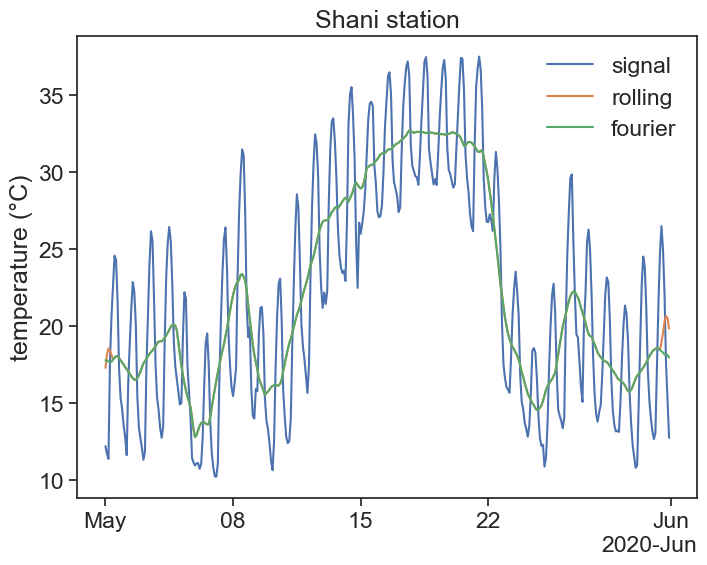

In [31]:
#| code-summary: "compare both methods"
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(df['T'], label="signal")
ax.plot(df['rolling1day'], label="rolling")
ax.plot(df.index, filtered, label="fourier")
ax.set(ylabel="temperature (°C)",
        xlabel="",
        title="Shani station")
ax.legend(frameon=False)
concise(ax);

## now let's play some more

What would we get if we changed the width of the window? In the example above the boxcar window had a width of 1 day. Let's see what happens when we chose windows of width 2 days and 1.5 days.

In [38]:
#| code-fold: false
# boxcar (rectangular) window
width_hours_2days = 48
width_points_2days = int(width_hours_2days/dt)
boxcar_2days = signal.windows.boxcar(width_points_2days)
boxcar_2days = boxcar_2days / np.sum(boxcar_2days)
boxcar_2days_array = np.zeros(N)
boxcar_2days_array[:width_points_2days] = boxcar_2days
boxcar_2days_array = np.roll(boxcar_2days_array, -width_points_2days//2)
fft_boxcar_2days_orig = scipy.fft.fft(boxcar_2days_array)
fft_boxcar_2days = scipy.fft.fftshift(fft_boxcar_2days_orig)
fft_abs_boxcar_2days = np.abs(fft_boxcar_2days)

width_hours_15days = 36
width_points_15days = int(width_hours_15days/dt)
boxcar_15days = signal.windows.boxcar(width_points_15days)
boxcar_15days = boxcar_15days / np.sum(boxcar_15days)
boxcar_15days_array = np.zeros(N)
boxcar_15days_array[:width_points_15days] = boxcar_15days
boxcar_15days_array = np.roll(boxcar_15days_array, -width_points_15days//2)
fft_boxcar_15days_orig = scipy.fft.fft(boxcar_15days_array)
fft_boxcar_15days = scipy.fft.fftshift(fft_boxcar_15days_orig)
fft_abs_boxcar_15days = np.abs(fft_boxcar_15days)

fft_filtered_20 = fft_orig * fft_boxcar_2days_orig
fft_filtered_15 = fft_orig * fft_boxcar_15days_orig
filtered20 = scipy.fft.ifft(fft_filtered_20).real
filtered15 = scipy.fft.ifft(fft_filtered_15).real

We see that when the width is an integer multiple of the fundamental period of oscillation of the signal, the filtering will eliminate all the harmonics. However, if we are not careful with our window width choice (e.g. 36 hours), many of the harmonics will be left untouched!

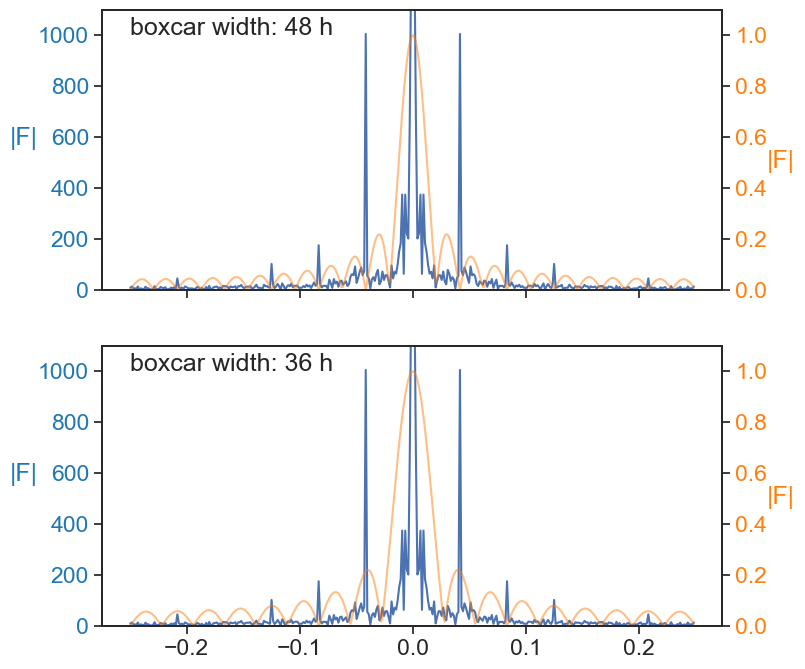

In [45]:
#| code-summary: "power spectrum of signal and window function"
fig, ax = plt.subplots(2, 1, figsize=(8,8), sharex=True)

ax[0].plot(xi, fft_abs, label="temperature")
ax[0].set_ylabel("|F|", color="tab:blue", rotation="horizontal", labelpad=10)
ax21 = ax[0].twinx()
ax21.plot(xi, fft_abs_boxcar_2days, label="boxcar", color="tab:orange", alpha=0.5)
ax21.set_ylabel("|F|", color="tab:orange", rotation="horizontal", labelpad=10)
ax[0].set(ylim=[0, 1100])
ax21.set(ylim=[0,1.1])
[t.set_color("tab:blue") for t in ax[0].yaxis.get_ticklines()]
[t.set_color("tab:blue") for t in ax[0].yaxis.get_ticklabels()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklines()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklabels()]
ax[0].text(-0.25, 1000, "boxcar width: 48 h")

ax[1].plot(xi, fft_abs, label="temperature")
ax[1].set_ylabel("|F|", color="tab:blue", rotation="horizontal", labelpad=10)
ax21 = ax[1].twinx()
ax21.plot(xi, fft_abs_boxcar_15days, label="boxcar", color="tab:orange", alpha=0.5)
ax21.set_ylabel("|F|", color="tab:orange", rotation="horizontal", labelpad=10)
ax[1].set(ylim=[0, 1100])
ax21.set(ylim=[0,1.1])
[t.set_color("tab:blue") for t in ax[1].yaxis.get_ticklines()]
[t.set_color("tab:blue") for t in ax[1].yaxis.get_ticklabels()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklines()]
[t.set_color("tab:orange") for t in ax21.yaxis.get_ticklabels()]
ax[1].text(-0.25, 1000, "boxcar width: 36 h");

To sum up, let's see what happens when we chose different window widths.

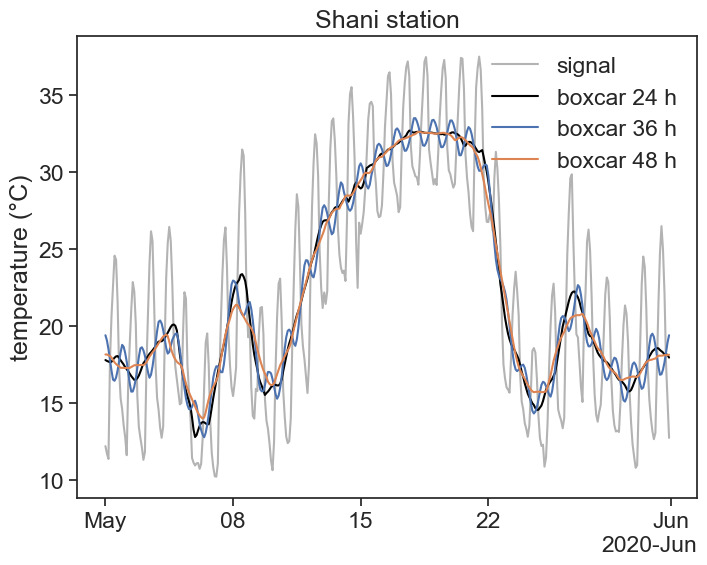

In [47]:
#| code-summary: "compare both methods"
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(df['T'], label="signal", color=[0.7]*3)
ax.plot(df.index, filtered, label="boxcar 24 h", color="black")
ax.plot(df.index, filtered15, label="boxcar 36 h")
ax.plot(df.index, filtered20, label="boxcar 48 h")
ax.set(ylabel="temperature (°C)",
        xlabel="",
        title="Shani station")
ax.legend(frameon=False, loc="upper right")
concise(ax);